In [1]:
# Importation librairies
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

plt.style.use('./mplstyle/projet-6.mplstyle')

In [2]:
colors = plt.rcParams["axes.prop_cycle"]

<img src='./images/logo-lapage-sans-fond.png' width=240px />

# Analysez les ventes d'une librairie avec Python

Nous sommes consultant *Data Analyst*, rattaché au service Marketing chez Lapage qui est une grande librairie en ligne très réputée. Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. L’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc..

## Sommaire<a id='0'></a>

* [Préparation des données source](#1)
    * [Importation](#1-1)
    * [Type des données](#1-2)
    * [Enregistrements test](#1-3)
    * [Valeurs manquantes](#1-4)
    * [Doublons ids](#1-5)
    * [Cohérence des données](#1-6)
    * [Regroupement des bases](#1-7)
* [Indicateurs de vente](#2)
    * [Chiffres clés](#2-1)
    * [Evolution du chiffre d'affaires dans le temps](#2-2)
    * [Moyenne mobile du chiffre d'affaires](#2-3)
    * [Zoom sur les références](#2-4)
    * [Zoom sur les clients](#2-5)
    * [Traffic](#2-6)
* [Analyse clients](#3)

## Préparation des données source<a id='1'></a>

Un traitement identique est appliqué, si nécessaire, à chaque fichier CSV qui compose la base données :
* chargement dans un *DataFrame* ;
* vérification de l'importation ;
* renommage des variables ;
* vérification du type des données ;
* suppression des variables inutiles ;
* vérification des valeurs manquantes et/ou des doublons.

Les *DataFrames* seront ensuite regroupés afin de nous permettre de mener les analyses demandées.

### Importation<a id='1-1'></a>

In [3]:
df_products = pd.read_csv('./datasets/products.csv')
df_customers = pd.read_csv('./datasets/customers.csv')
df_transactions = pd.read_csv('./datasets/transactions.csv')

In [4]:
df_products.head(3)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0


In [5]:
df_customers.head(3)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984


In [6]:
df_transactions.head(3)

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714


Il ne semble pas y avoir de variables à supprimer. Par contre, pour faciliter la compréhension, les noms de variables abrégés vont être renommés de manière explicite et vont être harmonisés.

In [7]:
df_products = df_products.rename(
    columns={'id_prod': 'product_id', 'categ': 'category'})

df_customers = df_customers.rename(columns={'birth': 'birth_year'})

df_transactions = df_transactions.rename(
    columns={'id_prod': 'product_id', 'date': 'transaction_date'})

Voyons les dimensions des jeux de données.

In [8]:
print(f'Dimensions de "df_products" : {df_products.shape}')
print(f'Dimensions de "df_customers" : {df_customers.shape}')
print(f'Dimensions de "df_transactions" : {df_transactions.shape}')

Dimensions de "df_products" : (3287, 3)
Dimensions de "df_customers" : (8623, 3)
Dimensions de "df_transactions" : (679532, 4)


### Type des données<a id='1-2'></a>

In [9]:
df_products.dtypes

product_id     object
price         float64
category        int64
dtype: object

"category" est une variable quantitative qui prend un nombre fini de valeurs, nous allons changer sont en "category" justement.

In [10]:
df_products['category'] = df_products['category'].astype('category')

In [11]:
df_customers.dtypes

client_id     object
sex           object
birth_year     int64
dtype: object

Pour la même raison, la même modification va être faite pour "sex" et "birth_year".

In [12]:
df_customers['sex'] = df_customers['sex'].astype('category')
df_customers['birth_year'] = df_customers['birth_year'].astype('category')

In [13]:
df_transactions.dtypes

product_id          object
transaction_date    object
session_id          object
client_id           object
dtype: object

Ici, seule la date n'est pas dans le bon format.

In [14]:
try:
    df_transactions['transaction_date'] = pd.to_datetime(
        df_transactions['transaction_date'])
except ValueError as erreur:
    print(erreur)

Unknown string format: test_2021-03-01 02:30:02.237419 present at position 3019


La conversion a échoué et on constate que la ligne 3019 ligne contient la mention "test_" avant la date. Voyons si d'autres lignes sont concernées.

In [15]:
df_transactions.loc[df_transactions['transaction_date'].str.contains('test')]

,product_id,transaction_date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


200 lignes correspondent à des tests. Supprimons-les pour ne pas fausser les futures analyses puis, revenons au traitement de la date.<br>
&#9888; Notons qu'il existe également un ou des produit(s) test ("T_") et des clients test ("ct_") qu'il faudra supprimer des *DataFrames* concernés.

In [16]:
# Suppression lignes de test
df_transactions = df_transactions.drop(
    df_transactions.query('transaction_date.str.contains("test")').index
).reset_index(drop=True)

# Conversion date
df_transactions['transaction_date'] = pd.to_datetime(
    df_transactions['transaction_date'])

### Enregistrements test<a id='1-3'></a>

Nous avons trouvé dans les transactions des lignes qui correspondent à des tests. On doit retrouver les produits et clients correspondant dans leur *DataFrame* respectif.

In [17]:
df_products.query('product_id.str.contains("T")')

,product_id,price,category
731,T_0,-1.0,0


In [18]:
df_customers.query('client_id.str.contains("ct")')

,client_id,sex,birth_year
2735,ct_0,f,2001
8494,ct_1,m,2001


Il y a donc un produit test, un client test féminin et un client test masculin à supprimer.

In [19]:
df_products = df_products.drop(
    df_products.query('product_id.str.contains("T")').index
).reset_index(drop=True)

df_customers = df_customers.drop(
    df_customers.query('client_id.str.contains("ct")').index
).reset_index(drop=True)

### Valeurs manquantes<a id='1-4'></a>

In [20]:
na_products = df_products.isna().sum().sum()
print(f'Nombre de valeurs manquantes dans "df_products" : {na_products}.')

na_customers = df_customers.isna().sum().sum()
print(f'Nombre de valeurs manquantes dans "df_customers" : {na_customers}.')

na_transactions = df_transactions.isna().sum().sum()
print(
    f'Nombre de valeurs manquantes dans "df_transactions" : {na_transactions}.')

del na_products, na_customers, na_transactions

Nombre de valeurs manquantes dans "df_products" : 0.
Nombre de valeurs manquantes dans "df_customers" : 0.
Nombre de valeurs manquantes dans "df_transactions" : 0.


Tous nos jeux de données sont complets.

### Doublons ids<a id='1-5'></a>

In [21]:
duplicate_products = df_products.duplicated(subset='product_id').sum()
print(f'Nombre de doublons dans "df_products" : {duplicate_products}.')

duplicate_customers = df_customers.duplicated(subset='client_id').sum()
print(f'Nombre de doublons dans "df_customers" : {duplicate_customers}.')

# On vérifie que les transactions sont uniques pour une date donnée
duplicate_transactions = df_transactions.duplicated(
    subset=['session_id', 'transaction_date']).sum()
print(f'Nombre de doublons dans "df_transactions" : {duplicate_transactions}.')

del duplicate_products, duplicate_customers, duplicate_transactions

Nombre de doublons dans "df_products" : 0.
Nombre de doublons dans "df_customers" : 0.
Nombre de doublons dans "df_transactions" : 0.


### Cohérence des données<a id='1-6'></a>

* Les catégories des produits sont-elles en nombre limité et y-a-t'il des valeurs qui semblent incohérentes ?

In [22]:
categories = df_products['category'].unique().tolist()
print(f'Les différentes catégories sont : {categories}.')
del categories

Les différentes catégories sont : [0, 1, 2].


* Le premier caractère de "product_id" correspond à la catégorie du produit ?

In [23]:
test_id_category = (df_products['product_id'].str[0].astype('int')
                    == df_products['category'].astype('int')).all()
print(
    f'Le premier caractère de "product_id" est la catégorie : {test_id_category}.')
del test_id_category

Le premier caractère de "product_id" est la catégorie : True.


* Des produits ont-ils un prix inférieur ou égal à 0 ?

In [24]:
test_price = (df_products['price'] <= 0).any()
print(f'Tous les prix sont bien ≥ 0 : {~test_price}.')
del test_price

Tous les prix sont bien ≥ 0 : True.


* Le sexe des clients est-il toujours soit "f", soit "m" ?

In [25]:
genders = df_customers['sex'].unique().tolist()
print(f'Les différentes valeurs de "sex" sont : {genders}.')
del genders

Les différentes valeurs de "sex" sont : ['f', 'm'].


* Les années de naissances des clients sont-elles cohérentes ?

In [26]:
df_customers['birth_year'].unique().sort_values()

[1929, 1930, 1931, 1932, 1933, ..., 2000, 2001, 2002, 2003, 2004]
Length: 76
Categories (76, int64): [1929, 1930, 1931, 1932, ..., 2001, 2002, 2003, 2004]

Les valeurs sont comprises entre 1929 et 2004 et il n'y a que des années composées de quatre chiffres.

* Les transactions sont-elles enregistrées sur des années cohérentes avec la date d'ouverture du site en ligne ?

In [27]:
df_transactions['transaction_date'].dt.year.value_counts().sort_index()

2021    278335
2022    346500
2023     54497
Name: transaction_date, dtype: int64

Le site a ouvert il y a deux ans et il y a des transactions sur trois années. Vérifions qu'il n'y a bien que deux ans d'enregistrements.

In [28]:
first_date = df_transactions['transaction_date'].min()
last_date = df_transactions['transaction_date'].max()
print(
    f'Date du premier enregistrement : {first_date}.\n'
    f'Date du dernier enregistrement : {last_date}.'
)
del first_date, last_date

Date du premier enregistrement : 2021-03-01 00:01:07.843138.
Date du dernier enregistrement : 2023-02-28 23:58:30.792755.


Le site n'a pas été mis en ligne au mois de janvier ce qui explique qu'il y ait trois années dans les données.

### Regroupement des bases<a id='1-7'></a>

On ajoute aux transactions les informations concernant les produits et les clients dans un nouveau *DataFrame* appelé `df_final`.

In [29]:
# Ajout des informations produits
df_final = pd.merge((df_transactions), (df_products),
                    on=['product_id'], how='left')

# Ajout des informations clients
df_final = pd.merge((df_final), (df_customers), on=['client_id'], how='left')

df_final.head(3)

,product_id,transaction_date,session_id,client_id,price,category,sex,birth_year
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0,f,1986
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1,m,1988
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0,f,1968


Les données semblent correctes, voyons la taille du nouveau jeu de données.

In [30]:
print(f'Les dimensions de "df_final" sont: {df_final.shape}')

Les dimensions de "df_final" sont: (679332, 8)


Le nombre de lignes est bon. `df_transactions` avait 679532 enregistrements desquels nous avons supprimé 200 test.<br>
Pour faciliter la lecture, nous allons réorganiser l'ordre des colonnes.

In [31]:
df_final = df_final[['session_id', 'transaction_date', 'product_id',
                     'category', 'price', 'client_id', 'sex', 'birth_year',]]

En fin, vérifions si il y a des valeurs manquantes.

In [32]:
df_final.isna().sum()

session_id            0
transaction_date      0
product_id            0
category            221
price               221
client_id             0
sex                   0
birth_year            0
dtype: int64

221 enregistrements n'ont ni prix, ni catégorie. Voyons combien de produits sont concernés.

In [33]:
# Calcul nombre de produits sans prix/catégorie
products_na = df_final['product_id'].isna().nunique()
products_sum = df_final['product_id'].nunique()
print(f'Il y a {products_na} produit(s) non renseigné(s) sur {products_sum}.')

# Calcul pourcentage transactions concernées
pct_transactions_na = df_final.isna().any(
    axis='columns').sum() / len(df_final.index)
print(f'Cela représente {pct_transactions_na:.3%} des transactions.')

del products_na, products_sum, pct_transactions_na

Il y a 1 produit(s) non renseigné(s) sur 3266.
Cela représente 0.033% des transactions.


Supprimer ces lignes n'aura donc pas d'impact sur les analyses.

In [34]:
df_final = df_final.dropna(axis='rows', how='any').reset_index(drop=True)

Le jeu de données final est prêt. Les *DataFrames* sources ne sont plus utiles, on peut les supprimer.

In [35]:
del df_products, df_customers, df_transactions

## Indicateurs de vente<a id='2'></a>

Pour réaliser les analyses de chiffre d'affaires, il va être nécessaire de regrouper les données par date mais à différentes fréquences. Pour éviter de devoir manipuler à chaque fois le *DataFrame*, il est plus simple de créer une fonction que l'on va pouvoir appeler dès que nécessaire. Elle va retourner un *DataFrame* modifié prêt à être utilisé.

In [36]:
def time_grouped_df(
        df,
        freq,
        start_date='2021-03-01',
        end_date='2023-02-28',
        cat=[0, 1, 2],
        detail=False
):
    """
    Groupe les prix du DataFrame selon une fréquence (année, mois, etc.) en 
    pouvant spécifier la date de début, la date de fin et la ou les catégorie(s).
    Il est également possible de grouper les prix par fréquence et par catégorie
    si "detail=True".
    """
    if detail == False:
        df_grouped = (
            (
                df.loc[
                    (df['transaction_date'].dt.normalize() >= start_date)
                    & (df['transaction_date'].dt.normalize() <= end_date)
                    & (df['category'].isin(cat))
                ].sort_values('transaction_date')
            )
            .groupby(pd.Grouper(key='transaction_date', freq=freq))[
                'price'
            ]
            .sum()
            .reset_index()
        )

    elif detail == True:
        df_grouped = (
            (
                df.loc[
                    (df['transaction_date'].dt.normalize() >= start_date)
                    & (df['transaction_date'].dt.normalize() <= end_date)
                    & (df['category'].isin(cat))
                ].sort_values('transaction_date')
            )
            .groupby(
            [pd.Grouper(key='transaction_date', freq=freq), 'category'])[
                'price'
            ]
            .sum()
            .reset_index()
        )

    return df_grouped

### Chiffres clés<a id='2-1'></a>

Pour commencer, quelques chiffres généraux, tels que :
* le résultat par année ;
* quelques indicateurs mensuels.

In [37]:
def table_TO_per_year():
    df_temp = df_final[['transaction_date', 'price']].copy()
    df_temp['transaction_date'] = df_temp['transaction_date'].dt.year
    df_temp = df_temp.groupby('transaction_date').sum()

    years = df_temp.index
    turnovers = round(df_temp['price'] / 1000, 2)
    total_turnover = round(df_temp['price'].sum() / 1000, 2)

    print(f'Chiffre d\'affaires annuel :')

    for year, turnover in zip(years, turnovers):
        print(f'- {year} :  {turnover:>12} k€')

    print(f'- Total : {total_turnover:>12} k€')


table_TO_per_year()

Chiffre d'affaires annuel :
- 2021 :       4770.83 k€
- 2022 :       6108.68 k€
- 2023 :        974.22 k€
- Total :     11853.73 k€


In [38]:
def table_TO_per_month():
    df = time_grouped_df(df_final, freq='MS')

    items = ['Minimum', 'Maximum', 'Moyen', 'Médian']
    values = [df['price'].min() / 1000, df['price'].max() / 1000,
              df['price'].mean() / 1000, df['price'].median() / 1000]

    print(f'Chiffre d\'affaires mensuel :')

    for item, value in zip(items, values):
        print(f'- {item} :\t{value:.2f} k€')


table_TO_per_month()

Chiffre d'affaires mensuel :
- Minimum :	320.80 k€
- Maximum :	535.57 k€
- Moyen :	493.91 k€
- Médian :	501.57 k€


### Evolution du chiffre d'affaires dans le temps<a id='2-2'></a>

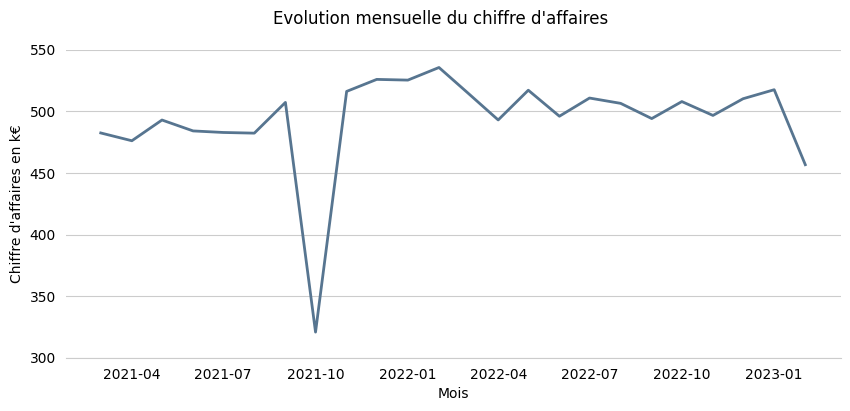

In [39]:
def plot_TO_per_month():
    df = time_grouped_df(df_final, freq='MS')

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.set_xlabel('Mois')

    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: format(int(x / 1000))))
    ax.set_ylim(300000, 550000)
    ax.set_ylabel('Chiffre d\'affaires en k€')

    ax.plot('transaction_date', 'price', data=df)

    fig.suptitle('Evolution mensuelle du chiffre d\'affaires')

    plt.show()


plot_TO_per_month()

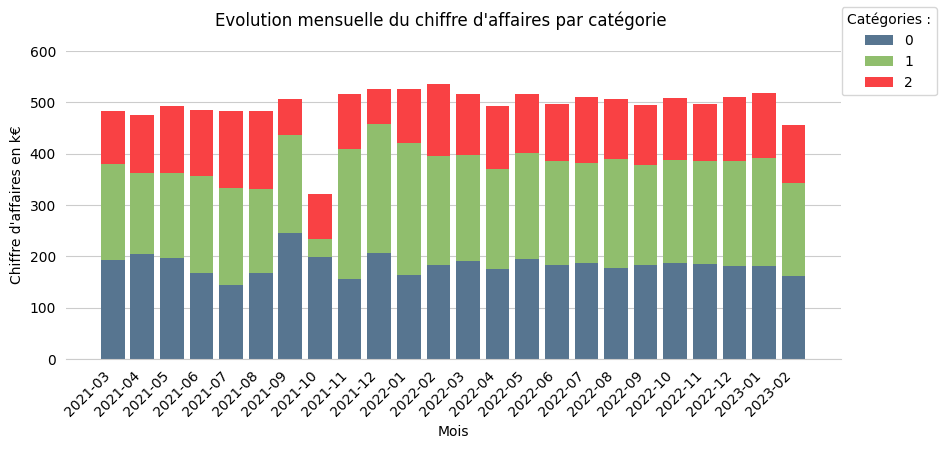

In [40]:
def plot_TO_per_month_per_category():
    df = time_grouped_df(df_final, freq='MS', detail=True)

    categories = df['category'].unique()
    dates = df['transaction_date'].unique()
    bar_position = np.arange(len(dates))
    bar_bottom = np.zeros(len(dates))
    bar_label = np.datetime_as_string(dates, unit='M')

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.set_xticks(np.arange(len(dates)))
    ax.set_xticklabels(bar_label, rotation=45, ha='right')
    ax.set_xlabel('Mois')

    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: format(int(x / 1000))))
    ax.set_ylim(0, 600000)
    ax.set_ylabel('Chiffre d\'affaires en k€')

    for i in range(len(categories)):
        values = df.loc[df['category'] == i, 'price']
        ax.bar(bar_position, values, bottom=bar_bottom, zorder=2)
        bar_bottom = np.add(bar_bottom, values).tolist()

    fig.suptitle('Evolution mensuelle du chiffre d\'affaires par catégorie')
    fig.legend(categories, title='Catégories :')

    plt.show()


plot_TO_per_month_per_category()

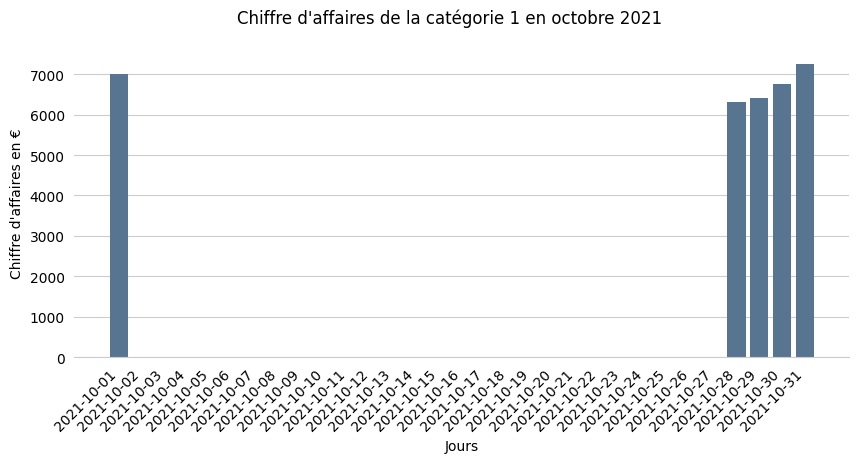

In [41]:
def plot_TO_per_day_per_category():
    df = time_grouped_df(
        df_final, freq='D', start_date='2021-10-01', end_date='2021-10-31', cat=[1])

    dates = df['transaction_date'].unique()
    values = df['price']
    bar_position = np.arange(len(dates))
    bar_label = np.datetime_as_string(dates, unit='D')

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.set_xticks(np.arange(len(dates)))
    ax.set_xticklabels(bar_label, rotation=45, ha='right')
    ax.set_xlabel('Jours')

    ax.set_ylabel('Chiffre d\'affaires en €')

    ax.bar(bar_position, values, zorder=2)

    fig.suptitle('Chiffre d\'affaires de la catégorie 1 en octobre 2021')

    plt.show()


plot_TO_per_day_per_category()

### Moyenne mobile du chiffre d'affaires<a id='2-3'></a>

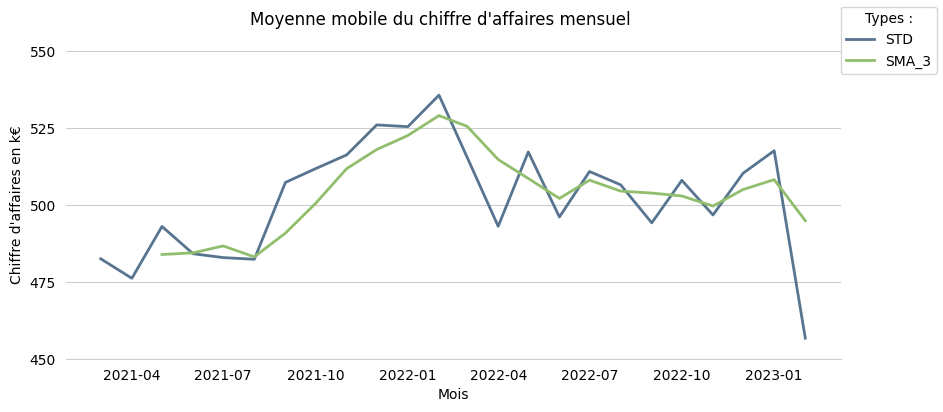

In [42]:
def plot_TO_per_month_moving_avg(window=3, span=3):
    df = time_grouped_df(df_final, freq='MS')

    row_to_correct = df.loc[df['transaction_date'] == '2021-10-01'].index[0]

    df.at[row_to_correct, 'price'] = (
        df.at[row_to_correct - 1, 'price'] + df.at[row_to_correct + 1, 'price']
    ) / 2

    df['SMA'] = df['price'].rolling(window=window).mean()
    df['CMA'] = df['price'].expanding().mean()
    df['EWMA'] = df['price'].ewm(span=span).mean()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.set_xlabel('Mois')

    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: format(int(x / 1000))))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(25000))
    ax.set_ylim(450000, 550000)
    ax.set_ylabel('Chiffre d\'affaires en k€')

    ax.plot('transaction_date', 'price', data=df, label='STD')
    ax.plot('transaction_date', 'SMA', data=df, label=('SMA_' + str(window)))
    # ax.plot('transaction_date', 'CMA', data=df, label='CMA')
    # ax.plot('transaction_date', 'EWMA', data=df, label='EWMA')

    fig.legend(title='Types :')
    fig.suptitle('Moyenne mobile du chiffre d\'affaires mensuel')

    plt.show()


plot_TO_per_month_moving_avg()

### Zoom sur les références<a id='2-4'></a>

In [43]:
def product_grouped_df(df):
    df_grouped = df.groupby(['category', 'product_id']).agg(
        {'product_id': 'count', 'price': 'sum'})
    df_grouped = df_grouped.rename(
        columns={'product_id': 'quantity', 'price': 'turnover'})
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.loc[df_grouped['quantity'] != 0]

    return df_grouped

#### Les top & les flops

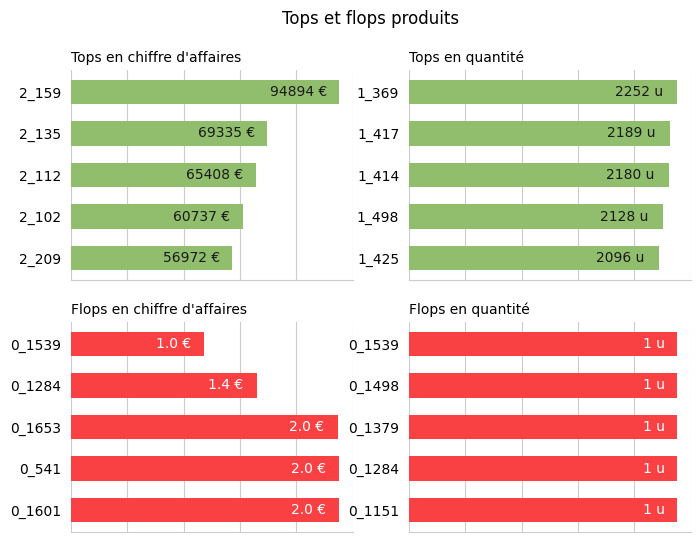

In [44]:
def plot_tops_flops():
    df = product_grouped_df(df_final)

    df_1 = df.nlargest(5, 'turnover')[
        ['product_id', 'turnover']].sort_values(by='turnover')
    df_2 = df.nsmallest(5, 'turnover')[
        ['product_id', 'turnover']].sort_values(by='turnover', ascending=False)
    df_3 = df.nlargest(5, 'quantity')[
        ['product_id', 'quantity']].sort_values(by='quantity')
    df_4 = df.nsmallest(5, 'quantity')[
        ['product_id', 'quantity']].sort_values(by='quantity', ascending=False)

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    bar_1 = axs[0, 0].barh(
        'product_id', 'turnover', data=df_1, zorder=2, color='#90be6d', height=0.60)
    bar_2 = axs[1, 0].barh(
        'product_id', 'turnover', data=df_2, zorder=2, color='#f94144', height=0.60)
    bar_3 = axs[0, 1].barh(
        'product_id', 'quantity', data=df_3, zorder=2, color='#90be6d', height=0.60)
    bar_4 = axs[1, 1].barh(
        'product_id', 'quantity', data=df_4, zorder=2, color='#f94144', height=0.60)

    axs[0, 0].bar_label(bar_1, fmt='{:.0f} €', padding=-50, color='0.1')
    axs[1, 0].bar_label(bar_2, fmt='{:.1f} €', padding=-35, color='1.0')
    axs[0, 1].bar_label(bar_3, fmt='{:.0f} u', padding=-45, color='0.1')
    axs[1, 1].bar_label(bar_4, fmt='{:.0f} u', padding=-25, color='1.0')

    for i in range(len(axs)):
        for j in range(len(axs[0])):
            axs[i][j].grid(visible=None)
            axs[i][j].set(xticklabels=[])
            axs[i][j].xaxis.set_major_locator(ticker.LinearLocator(numticks=6))

    fig.suptitle('Tops et flops produits')

    axs[0, 0].set_title('Tops en chiffre d\'affaires', size=10, loc='left')
    axs[1, 0].set_title('Flops en chiffre d\'affaires', size=10, loc='left')
    axs[0, 1].set_title('Tops en quantité', size=10, loc='left')
    axs[1, 1].set_title('Flops en quantité', size=10, loc='left')

    plt.show()


plot_tops_flops()

Les produits qui génèrent le plus de chiffre d'affaires ne sont pas les mêmes que ceux qui sont le plus vendu. Les produits vendus en plus grande quantités ne sont donc pas les plus chers. Peu d'informations sont exploitables avec les flops. A priori, plusieurs références n'ont été vendues qu'une seule fois. Voyons la distribution du nombre de ventes.

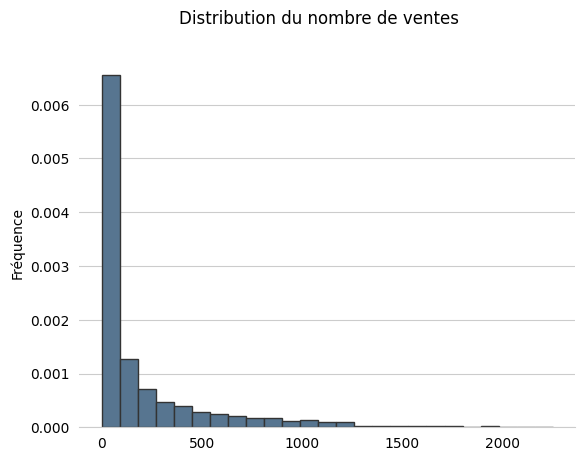

In [45]:
def plot_nbsales_distribution():
    df = product_grouped_df(df_final)
    
    fig, ax = plt.subplots()

    ax.hist(df['quantity'], density=True, bins=25, zorder=2, edgecolor='0.2')
    ax.set_ylabel('Fréquence')

    fig.suptitle('Distribution du nombre de ventes')

    plt.show()


plot_nbsales_distribution()

Une majorité de produits n'est vendu qu'un nombre assez faible de fois. Dans un objectif d'optimisation du nombre de références disponibles, il pourrait être intéressant de pousser les analyses sur ce point.

#### Répartition par catégorie

In [46]:
def table_QTY_per_category():
    df_temp = df_final[['category', 'product_id']].copy()
    df_temp = df_temp.groupby('category')['product_id'].nunique()
    
    categories = list(df_temp.index)
    quantities = df_temp.values
    total_quantity = df_temp.sum()

    print(f'Nombre de références par catégorie : ')

    for category, quantity in zip(categories, quantities):
        print(f'- Catégorie {category} : {quantity:>8}')

    print(f'- Total :\t{total_quantity:>8}')


table_QTY_per_category()

Nombre de références par catégorie : 
- Catégorie 0 :     2292
- Catégorie 1 :      737
- Catégorie 2 :      236
- Total :	    3265


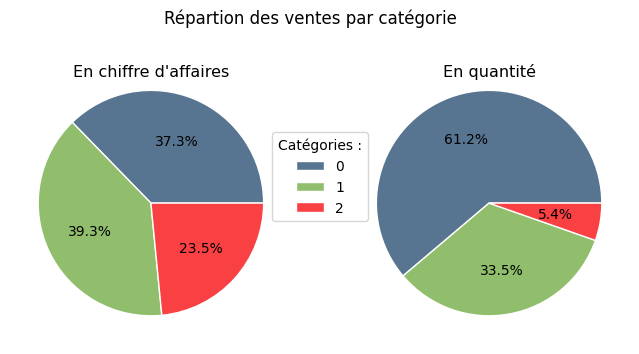

In [47]:
def plot_TO_QTY_per_category():
    df = product_grouped_df(df_final)

    categories = df['category'].unique()
    TO_sum = df.groupby('category')['turnover'].sum()
    QTY_sum = df.groupby('category')['quantity'].sum()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].pie(TO_sum, autopct='%.1f%%', wedgeprops={'edgecolor': '1.0'})
    axs[0].set_title('En chiffre d\'affaires', y=0.92, size=11.5)
    axs[1].pie(QTY_sum, autopct='%.1f%%', wedgeprops={'edgecolor': '1.0'})
    axs[1].set_title('En quantité', y=0.92, size=11.5)

    fig.suptitle('Répartion des ventes par catégorie')
    fig.legend(categories, title='Catégories :', loc='center')

    plt.show()


plot_TO_QTY_per_category()

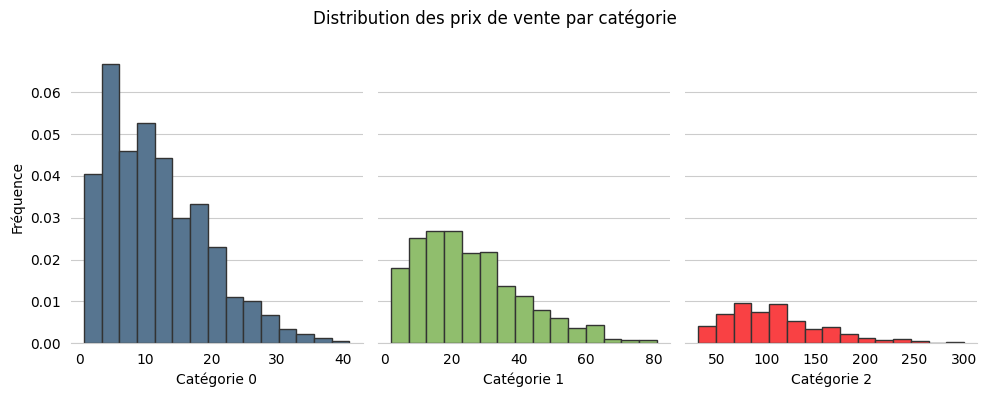

In [48]:
def plot_dist_price_per_category(bins):
    df_temp = df_final.drop_duplicates(subset=['product_id'], keep='first')[
        ['product_id', 'category', 'price']]

    fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

    categories = df_temp['category'].unique()
    colors = ['#577590', '#90be6d', '#f94144']

    for i in range(len(categories)):
        price_per_category = df_temp.loc[df_temp['category'] == i, :]

        axs[i].hist(price_per_category['price'], bins=bins, zorder=2,
                    edgecolor='0.2', density=True, color=colors[i])
        
        axs[i].set_xlabel('Catégorie ' + str(i))

    axs[0].set_ylabel('Fréquence')

    fig.suptitle('Distribution des prix de vente par catégorie')

    plt.tight_layout()
    plt.show()


plot_dist_price_per_category(bins=15)

In [59]:
def table_price_analysis():
    df_temp = df_final.drop_duplicates(subset=['product_id'], keep='first')[
        ['product_id', 'category', 'price']]

    categories = df_temp['category'].unique()
    items = [['Moyenne', 'Médiane', 'Minimal', 'Maximal', 'Ecart-type',
              'Skewness']]

    for category in categories:
        df_temp_category = df_temp.loc[df_temp['category'] == category, :]

        items.append([
            round(df_temp_category['price'].mean(), 2),
            round(df_temp_category['price'].median(), 2),
            round(df_temp_category['price'].min(), 2),
            round(df_temp_category['price'].max(), 2),
            round(df_temp_category['price'].std(ddof=0), 2),
            round(df_temp_category['price'].skew(), 2)
            ])

    table = pd.DataFrame(items).T
    table.columns = ['Indicateur', 'Catégorie 0', 'Catégorie 1', 'Catégorie 2']

    return table


table_price_analysis()

,Indicateur,Catégorie 0,Catégorie 1,Catégorie 2
0,Moyenne,11.71,25.5,107.64
1,Médiane,10.3,22.99,101.25
2,Minimal,0.62,2.0,30.99
3,Maximal,40.99,80.99,300.0
4,Ecart-type,7.53,15.42,49.15
5,Skewness,0.85,0.82,0.95


### Zoom sur les clients<a id='2-5'></a>

In [50]:
current_year = datetime.date.today().year
df_final['age'] = current_year - df_final['birth_year'].astype(int)
del current_year

#### Classement clients

In [51]:
df_final.groupby('client_id')['price'].sum().nlargest(10)

client_id
c_1609    324033.35
c_4958    289760.34
c_6714    153598.92
c_3454    113637.93
c_3263      5276.87
c_1570      5271.62
c_2899      5214.05
c_2140      5208.82
c_7319      5155.77
c_7959      5085.45
Name: price, dtype: float64

In [52]:
df_final.groupby('client_id')['price'].sum().nsmallest(5)

client_id
c_8351     6.31
c_8140     8.30
c_8114     9.98
c_240     11.06
c_4648    11.20
Name: price, dtype: float64

#### Profils clients

In [53]:
def table_client_analysis():
    df_temp = df_final.drop_duplicates(subset=['client_id'], keep='first')[
        ['sex', 'age']]

    sexes = df_temp['sex'].unique()
    list = [['Moyenne', 'Médiane', 'Minimal', 'Maximal']]

    for sex in sexes:
        df_temp_sex = df_temp.loc[df_temp['sex'] == sex, :]

        list.append([
            round(df_temp_sex['age'].mean(), 2),
            round(df_temp_sex['age'].median(), 2),
            round(df_temp_sex['age'].min(), 2),
            round(df_temp_sex['age'].max(), 2)
            ])

    table = pd.DataFrame(list).T
    table.columns = ['Indicateur d\'âge', sexes[0], sexes[1]]

    return table


table_client_analysis()

,Indicateur d'âge,f,m
0,Moyenne,45.03,44.43
1,Médiane,44.0,43.0
2,Minimal,19,19
3,Maximal,94,94


In [54]:
def table_gender_repartition():
    df_temp = df_final.drop_duplicates(subset=['client_id'], keep='first')[
        ['client_id', 'sex']]

    table = df_temp['sex'].value_counts(normalize=True).to_frame()
    
    table = table.rename(columns={'sex': 'Genre'},
                         index={'f': 'Femme', 'm': 'Homme'})

    return table.style.format('{:.1%}')


table_gender_repartition()

,Genre
Femme,52.1%
Homme,47.9%


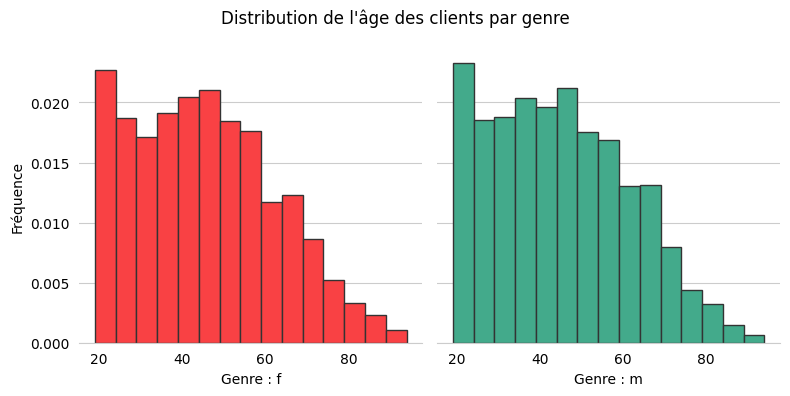

In [55]:
def plot_dist_age_per_sex(bins):
    df_temp = df_final.drop_duplicates(subset=['client_id'], keep='first')[
        ['client_id', 'sex', 'age']]

    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

    sexes = df_temp['sex'].unique()
    colors = ['#f94144', '#43aa8b']
    i = 0

    for sex in sexes:
        client_per_sex = df_temp.loc[df_temp['sex'] == sex]
        axs[i].hist(client_per_sex['age'], density=True, bins=bins,
                    zorder=2, edgecolor='0.2', color=colors[i])
        axs[i].set_xlabel('Genre : ' + sex)
        i += 1
    
    axs[0].set_ylabel('Fréquence')
    
    fig.suptitle('Distribution de l\'âge des clients par genre')
    
    plt.tight_layout()
    plt.show()


plot_dist_age_per_sex(15)

#### Répartition du chiffre d'affaires

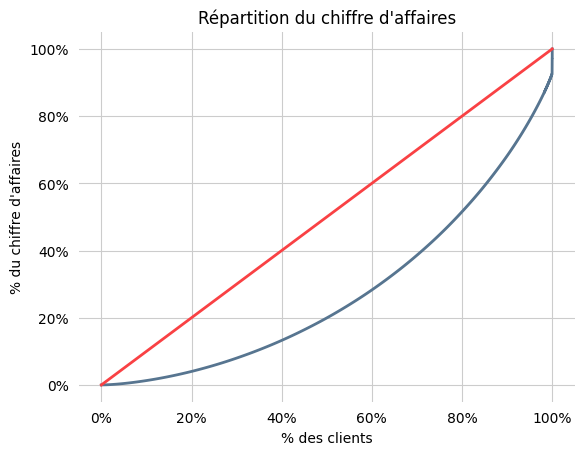

In [56]:
def lorenz_curve():
    df_temp = df_final.groupby('client_id')['price'].sum().reset_index()

    turnover = df_temp['price']

    n_turnover = len(turnover)

    cum_turnover = np.cumsum(np.sort(turnover)) / turnover.sum()
    cum_turnover = np.append([0], cum_turnover)

    cum_client = np.linspace(0-1/n_turnover, 1+1/n_turnover, len(cum_turnover))

    fig, ax = plt.subplots()

    ax.plot(cum_client, cum_turnover, drawstyle='steps-post')
    ax.plot([0, 1], [0, 1], color='#f94144')

    ax.grid(True)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

    ax.set_title('Répartition du chiffre d\'affaires')
    ax.set_xlabel('% des clients')
    ax.set_ylabel('% du chiffre d\'affaires')

    plt.show()


lorenz_curve()

### Traffic<a id='2-6'></a>

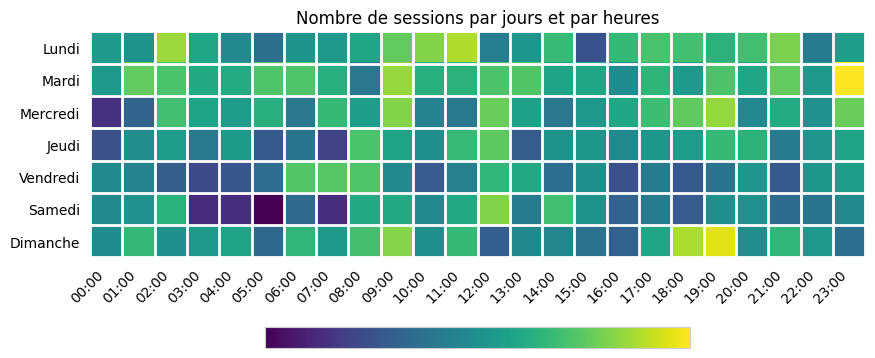

In [57]:
def plot_nb_sessions():
    df_temp = df_final[['session_id', 'transaction_date']].copy()

    df_temp['transaction_day'] = df_temp['transaction_date'].dt.dayofweek
    df_temp['transaction_hour'] = df_temp['transaction_date'].dt.hour

    df_temp = df_temp.groupby(['transaction_day', 'transaction_hour']
    ).agg({'session_id': 'count'}).reset_index()

    df_temp = pd.pivot_table(df_temp, index='transaction_day',
                             columns='transaction_hour')

    df_temp.columns = df_temp.columns.droplevel(0)

    day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi',
                 'Samedi', 'Dimanche']

    hours = df_temp.columns
    hour_names = []
    for hour in hours:
        hour_names.append(str(pd.to_timedelta(hour, unit='H'))[7:12])

    fig, ax = plt.subplots(figsize=(10, 6))

    im = ax.imshow(df_temp, interpolation='nearest')

    ax.set_xticks(np.arange(len(hour_names)))
    ax.set_xticklabels(hour_names, rotation=45, ha='right')
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

    ax.set_yticks(np.arange(len(day_names)))
    ax.set_yticklabels(day_names)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

    ax.grid(visible=False, which='major', axis='both')
    ax.grid(visible=True, which='minor', axis='both', color='1.0', linewidth=2)
    ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)

    ax.set_title('Nombre de sessions par jours et par heures')

    cb = fig.colorbar(im, location='bottom', shrink=0.6, fraction=0.046)
    cb.set_ticks([])

    plt.show()


plot_nb_sessions()

## Analyse clients<a id='3'></a>